In [1]:
# Colab 环境检测与依赖安装
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git@main
    !pip install -q git+https://github.com/bud-primordium/AtomPPGen.git@main


# AtomPPGen 教程 03：半局域势反演

本教程聚焦如何从 TM 伪轨道恢复半局域势 $V_l(r)$，以及如何通过诊断信息评估势的平滑性与节点行为。

## 教程目标
- 理解径向 Schrödinger 方程与半局域势的关系，掌握 $V_l = \varepsilon + \tfrac{1}{2}\tfrac{u''}{u} - \tfrac{l(l+1)}{2r^2}$ 的推导过程
- 比较内区（解析导数）与外区（样条导数）两种数值策略
- 学会检测节点、构建诊断表、绘制 $V_s/V_p/V_d$ 与核势 $-Z/r$ 的对比图

## 阅读建议
建议先完成 00-overview 和 02-tm-pseudization 教程，确保理解 TM 伪化的基本流程。


In [2]:
# 常用依赖与作图设置
import numpy as np
import matplotlib.pyplot as plt
import platform

from atomppgen import (
    solve_ae_atom,
    tm_pseudize,
    invert_semilocal_potential,
)

# 中文字体配置（兼容多平台）
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti']
elif platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
else:  # Linux / Colab
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
np.set_printoptions(precision=6, suppress=True)


## 反演公式推导

径向 Schrödinger 方程写成 TM 使用的 $u_l(r)$ 形式：
$$
-\frac{1}{2}\frac{d^2 u_l}{dr^2} + \left[\frac{l(l+1)}{2r^2} + V_l(r)\right] u_l(r) = \varepsilon_l\, u_l(r)
$$

把含势项移到等式右侧可以直接得到半局域势表达式：
$$
V_l(r) = \varepsilon_l + \frac{1}{2}\frac{u_l''(r)}{u_l(r)} - \frac{l(l+1)}{2r^2}
$$

内区（$r \le r_c$）的 TM 伪轨道可写成 $u_l(r) = r^{l+1} \exp p(r)$，其中 $p(r)=\sum_i a_{2i} r^{2i}$。代入有
$$
\frac{u_l''}{u_l} = \frac{l(l+1)}{r^2} + 2\frac{(l+1)p'(r)}{r} + p'(r)^2 + p''(r)
$$
因此
$$
V_l(r) = \varepsilon_l + (l+1)\frac{p'(r)}{r} + \tfrac{1}{2}\left[p'(r)^2 + p''(r)\right], \quad (r \le r_c)
$$
这条公式避开了 $u$ 与 $u''$ 的直接相除，在 TM 内区实现中可以利用多项式的解析导数计算。外区仍采用一般形式，只要能稳定评估 $u$ 与二阶导数即可。


## 内区（解析导数）与外区（样条）策略

| 区域 | 输入数据 | 数值策略 | 推荐场景 |
|------|----------|----------|----------|
| 内区 $r \le r_c$ | TM 系数 $a_{2i}$、角动量 $l$、能量 $\varepsilon$ | 利用 $p'(r), p''(r)$ 的解析表达直接带入公式 | 精确匹配 TM 多项式、避免 $u \to 0$ 导致除零 |
| 外区 $r > r_c$ | 全电子网格与拼接后的伪轨道 $u_{ps}(r)$ | 构建局域三次样条求 $u,u',u''$ | AE 区域本征方程成立，与核势保持一致 |

注意事项：
- 若外区跳变较大，可设置 `smooth_rc=True` 与 `smooth_width` 来平滑内外区接缝
- `V_max_clip` 限制 $u \to 0$ 时 $u''/u$ 的发散


## 节点区域与数值保护

- **节点检测**：`node_tol` 默认 $10^{-10}$，当 $|u(r)| < \text{node\_tol}$ 视作节点。`invert_semilocal_potential` 会把这些点的势暂存为占位值，待样条完成后再通过线性插值回填。
- **除零控制**：在节点附近 $u''/u$ 容易爆炸，因此需要先裁剪极端值（`V_max_clip`）。
- **诊断指标**：`diagnostics['n_nodes']` 会统计符号变化次数，可与全电子轨道节点数对比。


## 实战：Al (Z=13) 的 s/p/d 三通道反演

沿用前面教程的 Al 原子示例，对三个角动量通道进行势反演。


In [3]:
# 求解 AE 原子、构造 TM 伪轨道并反演 V_l(r)
Z = 13  # Al
rc_map = {0: 2.1, 1: 2.2, 2: 2.4}  # s/p/d 截断半径
channel_labels = {0: 's', 1: 'p', 2: 'd'}
colors = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'}

# 1) 全电子参考解
ae = solve_ae_atom(
    Z=Z,
    lmax=2,
    spin_mode="LDA",
    grid_type="exp_transformed",
    grid_params={"n": 1200, "total_span": 6.5},
)
print(f"AE 求解完成：网格点数 = {ae.r.size}, SCF 收敛 = {ae.converged}")

# 2) TM 伪化 + 势反演
tm_results = {}
inv_results = {}

for l, rc in rc_map.items():
    # 选取该通道能量最高的参考态（列表末尾；p/d 通道通常为近零散射态）
    u_ae = ae.u_by_l[l][-1]
    eps = ae.eps_by_l[l][-1]
    
    tm_res = tm_pseudize(
        r=ae.r,
        w=ae.w,
        u_ae=u_ae,
        eps=eps,
        l=l,
        rc=rc,
        continuity_orders=2,
    )
    tm_results[l] = tm_res

    inv_res = invert_semilocal_potential(
        tm_result=tm_res,
        r=ae.r,
        node_tol=1e-10,
        V_max_clip=1000.0,
    )
    inv_results[l] = inv_res

    diag = inv_res.diagnostics
    print(
        f"l={l} ({channel_labels[l]}) rc={rc:.2f} Bohr | "
        f"norm_err={tm_res.norm_error:.2e} | V(rc)={diag['V_at_rc']:.4f} Ha | n_nodes={diag['n_nodes']}"
    )


AE 求解完成：网格点数 = 1200, SCF 收敛 = True
l=0 (s) rc=2.10 Bohr | norm_err=1.59e-16 | V(rc)=-0.6049 Ha | n_nodes=0
l=1 (p) rc=2.20 Bohr | norm_err=4.65e-15 | V(rc)=-0.5551 Ha | n_nodes=1
l=2 (d) rc=2.40 Bohr | norm_err=2.10e-13 | V(rc)=-0.4696 Ha | n_nodes=2


## `invert_semilocal_potential` 参数说明

- `tm_result` / `r`：必须复用与 TM 相同的网格
- `node_tol`：越小越敏感，建议从 $10^{-10}$ 起调
- `V_max_clip`：裁剪 $u''/u$ 畸大值
- `smooth_rc` / `smooth_width`：可选的内外区平滑
- `diagnostics`：返回方法名、极值、rc 处势值、节点数等


In [4]:
# 汇总诊断信息
print(f"{'l':<3}{'ch':<5}{'rc (Bohr)':<12}{'n_nodes':<10}{'V_min (Ha)':<14}{'V_max (Ha)':<14}{'V(rc) (Ha)':<14}")
print('-' * 75)
for l in sorted(rc_map.keys()):
    diag = inv_results[l].diagnostics
    print(
        f"{l:<3}{channel_labels[l]:<5}{rc_map[l]:<12.2f}{diag['n_nodes']:<10d}"
        f"{diag['V_min']:<14.3f}{diag['V_max']:<14.3f}{diag['V_at_rc']:<14.3f}"
    )


l  ch   rc (Bohr)   n_nodes   V_min (Ha)    V_max (Ha)    V(rc) (Ha)    
---------------------------------------------------------------------------
0  s    2.10        0         -0.874        1.040         -0.605        
1  p    2.20        1         -0.754        -0.000        -0.555        
2  d    2.40        2         -3.469        0.000         -0.470        


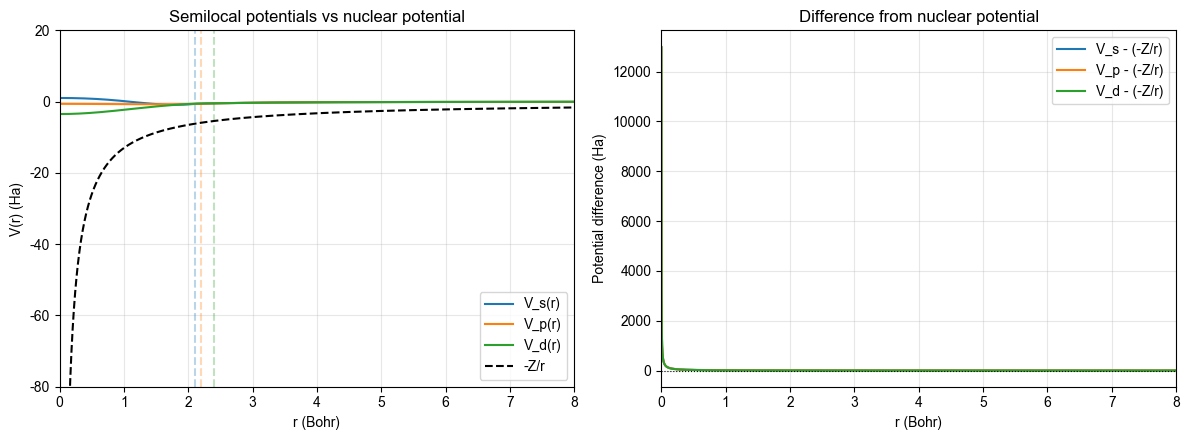

In [5]:
# 可视化 V_s / V_p / V_d 以及核势 -Z/r
r_mask = ae.r <= 8.0
r_vis = ae.r[r_mask]
r_safe = np.where(r_vis < 1e-3, 1e-3, r_vis)
V_nuc = -Z / r_safe

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: semilocal potentials vs nuclear
for l in sorted(rc_map.keys()):
    axes[0].plot(r_vis, inv_results[l].V_l[r_mask], 
                 label=f"V_{channel_labels[l]}(r)", color=colors[l])
    axes[0].axvline(rc_map[l], color=colors[l], linestyle='--', alpha=0.3)
axes[0].plot(r_vis, V_nuc, label='-Z/r', color='black', linestyle='--')
axes[0].set_xlabel('r (Bohr)')
axes[0].set_ylabel('V(r) (Ha)')
axes[0].set_title('Semilocal potentials vs nuclear potential')
axes[0].set_xlim(0, 8)
axes[0].set_ylim(-80, 20)
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Right: difference from nuclear potential
for l in sorted(rc_map.keys()):
    axes[1].plot(r_vis, inv_results[l].V_l[r_mask] - V_nuc, 
                 label=f"V_{channel_labels[l]} - (-Z/r)", color=colors[l])
axes[1].set_xlabel('r (Bohr)')
axes[1].set_ylabel('Potential difference (Ha)')
axes[1].set_title('Difference from nuclear potential')
axes[1].set_xlim(0, 8)
axes[1].axhline(0.0, color='black', linewidth=0.8, linestyle=':')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 小结与下一步

- 通过径向方程反演得到的 $V_l(r)$ 取决于 TM 内区解析导数与外区样条精度
- `diagnostics` 中的节点数、极值、rc 处势值可以快速暴露问题
- 与核势 $-Z/r$ 对比能直观判断局域道候选：通常选择最"排斥"的通道（如 d 道）作为 `V_loc`

**下一步**：进入 04-kb-transform 教程，将半局域势转换为 KB 可分离形式。
